# Lesson 3: AI-Powered NPCs and Intelligent Dialogue Systems

In this lesson, we'll learn:
- Integrating Large Language Models (LLMs) into game agents
- Dynamic NPC personalities and contextual dialogue
- Multi-agent conversations and negotiations
- Knowledge-enhanced decision making

## 🌙 World Setting: ตำนานนครากลับฟ้า - การสนทนากับวิญญาณโบราณ

**"คำพูด...มีพลังเปลี่ยนแปลงโชคชะตา...แต่ต้องรู้จักฟัง...และเข้าใจ"**

In this chapter of **ตำนานนครากลับฟ้า**, you'll encounter ancient spirits, mystical merchants, and wise monks who possess centuries of knowledge. Each NPC has their own personality, memories, and motivations. Through intelligent dialogue, you can:

- 🗣️ **สนทนาเชิงลึก**: Engage in meaningful conversations with ancient spirits
- 📚 **ศึกษาภูมิปัญญา**: Learn ancient Thai wisdom and mystical knowledge
- 💼 **เจรจาต่อรอง**: Negotiate with supernatural merchants
- 🔮 **รับภารกิจ**: Accept quests from enlightened masters
- 🌟 **สร้างพันธมิตร**: Build relationships that span across time cycles

### 🎯 Learning Objectives
- Master LLM integration for dynamic NPC behavior
- Create context-aware dialogue systems
- Build persistent NPC relationships across game sessions
- Design multi-turn conversation flows with branching outcomes

In [1]:
from typing import TypedDict, List, Dict, Optional, Literal, Any
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from dataclasses import dataclass, field
import json
import random
from datetime import datetime
import asyncio

# LLM integration imports
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

## NPC and Dialogue State Structures

In [2]:
# --- NPC and Dialogue State Structures ---
# This cell defines the data structures for NPC personalities, dialogue context, and the overall game state.
# - NPCPersonality: Describes each NPC's traits, knowledge, and memory.
# - DialogueContext: Tracks the current topic, mood, and available options in a conversation.
# - GameStateWithNPCs: Main game state, including player info, NPCs, relationships, and dialogue history.

@dataclass
class NPCPersonality:
    name: str
    type: Literal["spirit", "merchant", "monk", "guardian", "demon"]
    personality_traits: List[str]
    knowledge_domains: List[str]
    relationship_status: float  # -1.0 (hostile) to 1.0 (ally)
    dialogue_style: str
    memory_of_player: List[str] = field(default_factory=list)
    conversation_history: List[Dict] = field(default_factory=list)

@dataclass
class DialogueContext:
    current_topic: str
    player_intent: str
    npc_mood: str
    available_options: List[str]
    contextual_info: Dict[str, Any]

class GameStateWithNPCs(TypedDict):
    # Previous game state from lesson 2
    player_position: Dict[str, int]
    พลังชีวิต: int
    พลังชีวิตสูงสุด: int
    มานตรา: int
    inventory: List[Dict]
    current_area: str
    discovered_areas: List[str]
    current_cycle: int
    curse_progress: float
    completed_objectives: List[str]
    turn_count: int
    messages: List[str]
    
    # New NPC and dialogue state
    active_npcs: Dict[str, Dict]  # NPCs in current area
    npc_relationships: Dict[str, float]  # NPC relationship scores
    current_conversation: Optional[Dict]  # Active dialogue
    conversation_history: Dict[str, List[Dict]]  # Per-NPC history
    player_reputation: Dict[str, int]  # Reputation with factions
    knowledge_gained: List[str]  # Player's learned knowledge
    
    # LLM state (for future use)
    llm_context: Dict[str, Any]
    external_knowledge: Dict[str, Any]
    dialogue_options: List[str]

## LLM-Powered NPC System

In [3]:
# --- LLM-Powered NPC System ---
# This class defines an NPC that can generate dialogue using an LLM.
# For demonstration, we use simulated responses, but you can connect to a real LLM (see commented code).
from dotenv import load_dotenv
load_dotenv()

class IntelligentNPC:
    """LLM-powered NPC with personality and memory"""
    
    def __init__(self, personality: NPCPersonality, llm_model: str = "gpt-4o-mini"):
        self.personality = personality
        # To use a real LLM, uncomment the following line and provide your OpenAI API key:
        self.llm = ChatOpenAI(model=llm_model, temperature=0.7)
        # For this lesson, we use simulated responses for clarity and cost reasons.

    def create_system_prompt(self, game_context: Dict) -> str:
        """Create system prompt based on NPC personality and game context"""
        # This prompt guides the LLM to role-play as the NPC.
        base_prompt = f"""คุณคือ {self.personality.name} ({self.personality.type}) ในเกม ตำนานนครากลับฟ้า

บุคลิกภาพ: {', '.join(self.personality.personality_traits)}
ความรู้เฉพาะด้าน: {', '.join(self.personality.knowledge_domains)}
ความสัมพันธ์กับผู้เล่น: {self.personality.relationship_status:.1f} (-1=ศัตรู, 1=พันธมิตร)
สไตล์การพูด: {self.personality.dialogue_style}

บริบทปัจจุบัน:
- สถานที่: {game_context.get('current_area', 'ไม่ทราบ')}
- วัฏจักรกาล: {game_context.get('current_cycle', 1)}
- ระดับคำสาป: {game_context.get('curse_progress', 0):.1%}

จำไว้:
1. พูดแบบไทยโบราณผสมสมัยใหม่
2. แสดงอารมณ์และบุคลิกที่ชัดเจน
3. ใช้ความรู้เฉพาะด้านของคุณ
4. จำประวัติการสนทนาที่ผ่านมา
5. ตอบสนองตามความสัมพันธ์กับผู้เล่น

ตอบกลับในรูปแบบ JSON:
{{
    "text": "...ข้อความสนทนา...",
    "emotion": "...อารมณ์...",
    "relationship_change": ...ตัวเลขระหว่าง -1 ถึง 1...
}}
"""
        
        return base_prompt

    async def generate_response(self, player_message: str, game_context: Dict) -> Dict[str, Any]:
        prompt = self.create_system_prompt(game_context)
        messages = [
            SystemMessage(content=prompt),
            HumanMessage(content=player_message)
        ]
        ai_response = await self.llm.ainvoke(messages)
        try:
            response_data = json.loads(ai_response.content)
        except Exception:
            # fallback if LLM doesn't return valid JSON
            response_data = {
                "text": ai_response.content,
                "emotion": "neutral",
                "relationship_change": 0.0
            }
        # Update relationship_status
        self.personality.relationship_status += response_data.get("relationship_change", 0.0)
        # Clamp between -1 and 1
        self.personality.relationship_status = max(-1.0, min(1.0, self.personality.relationship_status))
        # Update memory
        self.personality.conversation_history.append({
            "player_message": player_message,
            "npc_response": response_data["text"],
            "timestamp": datetime.now().isoformat(),
            "context": game_context.copy()
        })
        return response_data

    def _get_simulated_responses(self, message: str, context: Dict) -> List[Dict]:
        # Simulated responses based on NPC type and player message.
        message_lower = message.lower()

        if self.personality.type == "spirit":
            if "คำสาป" in message or "curse" in message_lower:
                return [{
                    "text": "คำสาปนี้...เกิดจากความโกรธแค้นที่สั่งสมมานาน...ท่านต้องหาสาเหตุที่แท้จริง",
                    "emotion": "mysterious",
                    "knowledge_shared": "curse_origins",
                    "relationship_change": 0.1
                }]
            elif "วัด" in message or "temple" in message_lower:
                return [{
                    "text": "วัดเหล่านั้น...เป็นที่สถิตของพลังศักดิ์สิทธิ์...แต่ระวังวัดร้าง...มีสิ่งไม่ดีหลับใหล",
                    "emotion": "warning",
                    "knowledge_shared": "temple_secrets",
                    "relationship_change": 0.05
                }]

        elif self.personality.type == "merchant":
            if "ขาย" in message or "ซื้อ" in message or "trade" in message_lower:
                return [{
                    "text": "อาขาร...ท่านมีของดีมาแลกหรือ? ข้าต้องการพระเครื่องแท้...ไม่ใช่ของปลอม",
                    "emotion": "interested",
                    "action": "open_trade",
                    "relationship_change": 0.0
                }]

        elif self.personality.type == "monk":
            if "ธรรม" in message or "wisdom" in message_lower:
                return [{
                    "text": "ธรรมะสอนว่า...ทุกสิ่งล้วนเป็นอนิจจัง...แม้คำสาปนี้ก็เช่นกัน...หากเข้าใจได้",
                    "emotion": "wise",
                    "knowledge_shared": "buddhist_wisdom",
                    "relationship_change": 0.15
                }]

        # Default response
        return [{
            "text": "เอ่อ...ท่านพูดอะไรนะ? ข้าไม่เข้าใจ",
            "emotion": "confused",
            "relationship_change": -0.05
        }]

    def _select_contextual_response(self, responses: List[Dict], context: Dict) -> Dict:
        # Simple selection logic - can be enhanced with more sophisticated AI
        response = responses[0].copy()

        # Adjust response based on relationship
        if self.personality.relationship_status < -0.5:
            response["text"] = response["text"].replace("ท่าน", "คน") + " อย่ามารบกวนข้า!"
            response["emotion"] = "hostile"
        elif self.personality.relationship_status > 0.5:
            response["text"] = "เพื่อนรัก! " + response["text"]
            response["emotion"] = "friendly"

        return response

## Dialogue Management System

In [4]:
# --- Dialogue Management System ---
# This cell manages NPC initialization, starting conversations, and continuing dialogue.
# - initialize_npcs: Spawns NPCs in the current area.
# - start_conversation: Begins a conversation with an NPC.
# - continue_dialogue: Handles multi-turn dialogue, updates relationships, and tracks knowledge.

def initialize_npcs(state: GameStateWithNPCs) -> GameStateWithNPCs:
    """Initialize NPCs in the current area"""
    area = state['current_area']
    state['active_npcs'] = {}

    npc_definitions = {
        "วัดพระแก้วใต้ดิน": [
            NPCPersonality(
                name="พระราชาผีเก่า",
                type="spirit",
                personality_traits=["ปริศนา", "รอบรู้", "เฝ้าระวัง"],
                knowledge_domains=["คำสาป", "ประวัติศาสตร์", "วัฏจักรกาล"],
                relationship_status=0.0,
                dialogue_style="พูดแบบโบราณ ลึกลับ"
            )
        ],
        "ตลาดลอยฟ้า": [
            NPCPersonality(
                name="นายอุดมสมปรารถนา",
                type="merchant",
                personality_traits=["โลภ", "ฉลาด", "ไว้ใจไม่ได้"],
                knowledge_domains=["พระเครื่อง", "ราคาของ", "เส้นทางการค้า"],
                relationship_status=-0.2,
                dialogue_style="พูดแบบพ่อค้า เห็นแก่กำไร"
            )
        ],
        "ถ้ำวิปัสสนา": [
            NPCPersonality(
                name="หลวงปู่จันทร์",
                type="monk",
                personality_traits=["สงบ", "เมตตา", "รอบคอบ"],
                knowledge_domains=["ธรรมะ", "สมาธิ", "การปลดปล่อย"],
                relationship_status=0.3,
                dialogue_style="พูดนุ่มนวล สอนใจ"
            )
        ],
        "สวนภูตผี": [
            NPCPersonality(
                name="แม่หญิงภูต",
                type="spirit",
                personality_traits=["ขี้เล่น", "ลึกลับ", "ใจดี"],
                knowledge_domains=["พืชวิเศษ", "ภูตผี", "เวทมนตร์"],
                relationship_status=0.1,
                dialogue_style="พูดสนุกสนาน มีอารมณ์ขัน"
            )
        ],
        "วิหารโบราณ": [
            NPCPersonality(
                name="อาจารย์โบราณ",
                type="sage",
                personality_traits=["ฉลาด", "เคร่งขรึม", "เจ้าระเบียบ"],
                knowledge_domains=["ประวัติศาสตร์", "เวทโบราณ", "สัญลักษณ์ลับ"],
                relationship_status=0.0,
                dialogue_style="พูดจริงจัง ใช้ศัพท์โบราณ"
            )
        ],
        "ห้องสมุดแห่งกาล": [
            NPCPersonality(
                name="บรรณารักษ์เงา",
                type="librarian",
                personality_traits=["เงียบขรึม", "ช่างสังเกต", "รักความรู้"],
                knowledge_domains=["หนังสือหายาก", "ประวัติศาสตร์", "ความลับของกาลเวลา"],
                relationship_status=0.2,
                dialogue_style="พูดเบาๆ สุภาพ"
            )
        ]
    }

    # Extract base area name (strip coordinates if present)
    base_area = area.split('_')[0]

    # Add NPCs for current area
    if base_area in npc_definitions:
        for npc_personality in npc_definitions[base_area]:
            npc_id = f"{area}_{npc_personality.name}"  # Use full area for uniqueness
            state['active_npcs'][npc_id] = {
                "personality": npc_personality,
                "npc_instance": IntelligentNPC(npc_personality),
                "is_talking": False
            }
            if npc_id not in state['npc_relationships']:
                state['npc_relationships'][npc_id] = npc_personality.relationship_status

    state['messages'].append(f"พบ NPCs ในพื้นที่ {base_area}: {len(state['active_npcs'])} คน")
    return state

async def start_conversation(state: GameStateWithNPCs) -> GameStateWithNPCs:
    """Start conversation with an NPC"""
    if not state['active_npcs']:
        state['messages'].append("ไม่มี NPC ในพื้นที่นี้")
        return state
    
    # Select NPC to talk to (simple selection - first available)
    npc_id = list(state['active_npcs'].keys())[0]
    npc_data = state['active_npcs'][npc_id]
    npc_instance = npc_data['npc_instance']
    
    # Create dialogue context
    game_context = {
        "current_area": state['current_area'],
        "current_cycle": state['current_cycle'],
        "curse_progress": state['curse_progress'],
        "player_health": state['พลังชีวิต'],
        "player_mana": state['มานตรา'],
        "completed_objectives": state['completed_objectives']
    }
    
    # Generate greeting
    greeting_response = await npc_instance.generate_response("สวัสดี", game_context)
    
    # Set up conversation state
    state['current_conversation'] = {
        "npc_id": npc_id,
        "npc_name": npc_instance.personality.name,
        "turns": 0,
        "context": game_context,
        "last_response": greeting_response
    }
    
    npc_data['is_talking'] = True
    
    state['messages'].append(f"เริ่มสนทนากับ {npc_instance.personality.name}")
    state['messages'].append(f"{npc_instance.personality.name}: {greeting_response['text']}")
    
    return state

async def continue_dialogue(state: GameStateWithNPCs) -> GameStateWithNPCs:
    """Continue ongoing dialogue"""
    if not state['current_conversation']:
        return await start_conversation(state)
    
    conv = state['current_conversation']
    npc_id = conv['npc_id']
    npc_instance = state['active_npcs'][npc_id]['npc_instance']
    
    # Simulate player responses based on game state
    player_messages = [
        "คำสาปนี้เกิดจากอะไร?",
        "ท่านรู้จักวิธีทำลายคำสาปไหม?",
        "มีสิ่งของอะไรที่จะช่วยได้บ้าง?",
        "วัดไหนที่ควรไปสำรวจ?",
        "ข้าต้องการความช่วยเหลือ"
    ]
    
    # Select player message based on current needs
    if state['curse_progress'] > 0.7:
        player_msg = "คำสาปนี้เกิดจากอะไร?"
    elif state['พลังชีวิต'] < 30:
        player_msg = "ข้าต้องการความช่วยเหลือ"
    elif len(state['discovered_areas']) < 3:
        player_msg = "วัดไหนที่ควรไปสำรวจ?"
    else:
        player_msg = random.choice(player_messages)
    
    # Generate NPC response
    response = await npc_instance.generate_response(player_msg, conv['context'])
    
    # Update conversation state
    conv['turns'] += 1
    conv['last_response'] = response
    
    # Update relationship
    if 'relationship_change' in response:
        old_rel = state['npc_relationships'][npc_id]
        new_rel = max(-1.0, min(1.0, old_rel + response['relationship_change']))
        state['npc_relationships'][npc_id] = new_rel
        npc_instance.personality.relationship_status = new_rel
    
    # Add to conversation history
    if npc_id not in state['conversation_history']:
        state['conversation_history'][npc_id] = []
    
    state['conversation_history'][npc_id].append({
        "turn": conv['turns'],
        "player": player_msg,
        "npc": response['text'],
        "timestamp": datetime.now().isoformat()
    })
    
    # Process response actions
    if 'knowledge_shared' in response:
        knowledge_key = f"{npc_instance.personality.name}_{response['knowledge_shared']}"
        if knowledge_key not in state['knowledge_gained']:
            state['knowledge_gained'].append(knowledge_key)
            state['completed_objectives'].append(f"ได้รับความรู้: {response['knowledge_shared']}")
    
    if 'action' in response and response['action'] == 'open_trade':
        state['messages'].append("เปิดหน้าต่างการค้าขาย (จำลอง)")
    
    # Display conversation
    state['messages'].append(f"ผู้เล่น: {player_msg}")
    state['messages'].append(f"{npc_instance.personality.name}: {response['text']}")
    
    # End conversation after several turns or based on context
    if conv['turns'] >= 3 or random.random() < 0.3:
        state['messages'].append(f"จบการสนทนากับ {npc_instance.personality.name}")
        state['current_conversation'] = None
        state['active_npcs'][npc_id]['is_talking'] = False
    
    return state

## Enhanced Game Flow with NPCs

In [5]:
# --- Enhanced Game Flow with NPCs ---
# This cell defines exploration logic and end conditions.
# - enhanced_exploration: Moves the player, discovers new areas, and triggers NPC encounters.
# - should_continue_enhanced: Checks if the game should end (e.g., player dies, curse maxed, etc.).

def enhanced_exploration(state: GameStateWithNPCs) -> GameStateWithNPCs:
    """Enhanced exploration that may lead to NPC encounters"""
    # Move to new location
    directions = ['ทิศเหนือ', 'ทิศใต้', 'ทิศตะวันออก', 'ทิศตะวันตก']
    direction = random.choice(directions)
    
    if direction == 'ทิศเหนือ':
        state['player_position']['y'] += 1
    elif direction == 'ทิศใต้':
        state['player_position']['y'] -= 1
    elif direction == 'ทิศตะวันออก':
        state['player_position']['x'] += 1
    else:
        state['player_position']['x'] -= 1
    
    # Determine new area with NPCs
    areas_with_npcs = [
        "วัดพระแก้วใต้ดิน", "ตลาดลอยฟ้า", "ถ้ำวิปัสสนา", 
        "สวนภูตผี", "วิหารโบราณ", "ห้องสมุดแห่งกาล"
    ]
    
    new_area = f"{random.choice(areas_with_npcs)}_{state['player_position']['x']}_{state['player_position']['y']}"
    
    if new_area not in state['discovered_areas']:
        state['discovered_areas'].append(new_area)
        state['messages'].append(f"ค้นพบพื้นที่ใหม่: {new_area}")
        state['completed_objectives'].append(f"สำรวจ {new_area}")
        state['curse_progress'] = max(0, state['curse_progress'] - 0.03)
    
    state['current_area'] = new_area
    state['turn_count'] += 1
    
    return state

def should_continue_enhanced(state: GameStateWithNPCs) -> str:
    """Enhanced end condition checking"""
    if state['พลังชีวิต'] <= 0:
        return "end"
    if state['curse_progress'] >= 1.0:
        return "end"
    if state['current_cycle'] >= 5:  # Reduced for demo
        return "end"
    if len(state['knowledge_gained']) >= 5 and state['curse_progress'] <= 0.2:
        return "end"
    if state['turn_count'] >= 20:  # Limit turns for demo
        return "end"
    
    return "continue"

## Building the NPC-Enhanced Graph

In [6]:
# --- Building the NPC-Enhanced Graph ---
# This cell creates the workflow graph for the game loop using langgraph.
# Nodes: initialize_npcs -> explore -> dialogue (repeat until end condition).

memory = MemorySaver()
workflow = StateGraph(GameStateWithNPCs)

# Add nodes
workflow.add_node("initialize_npcs", initialize_npcs)
workflow.add_node("explore", enhanced_exploration)
workflow.add_node("dialogue", continue_dialogue)

# Set entry point
workflow.set_entry_point("initialize_npcs")

# Add edges
workflow.add_edge("initialize_npcs", "explore")
workflow.add_edge("explore", "dialogue")
workflow.add_conditional_edges(
    "dialogue",
    should_continue_enhanced,
    {
        "continue": "explore",
        "end": END
    }
)

# Compile
app_with_npcs = workflow.compile(checkpointer=memory)

In [7]:
# --- Visualization of the Game Graph ---
# This cell generates and saves a visualization of the game workflow graph.

import os
from datetime import datetime
from IPython.display import Image

visualization_path = "../visualizations"
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs(visualization_path, exist_ok=True)
image = Image(app_with_npcs.get_graph().draw_mermaid_png())
with open(
    f"{visualization_path}/{current_date}_graph.png", "wb"
) as f:
    f.write(image.data)

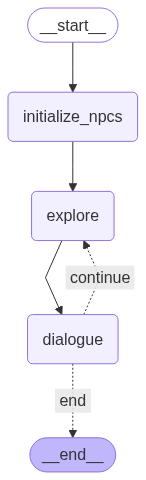

In [8]:
# --- Display the Game Graph ---
# This cell displays the workflow graph image in the notebook.

Image(app_with_npcs.get_graph().draw_mermaid_png())

## 🎮 Interactive NPC Dialogue Simulation

Experience intelligent conversations with AI-powered NPCs who remember your interactions, share ancient knowledge, and react dynamically to your choices and reputation.

In [9]:
# --- Interactive NPC Dialogue Simulation ---
# This cell runs the main game loop, simulating turns, exploration, and NPC conversations.
# It prints out the game state, recent messages, and relationship changes for tutorial/lecture clarity.

async def run_npc_dialogue_simulation():
    """Run simulation with intelligent NPCs and dialogue"""
    
    # Create initial state with NPC features
    initial_state = {
        "player_position": {"x": 0, "y": 0},
        "พลังชีวิต": 80,
        "พลังชีวิตสูงสุด": 100,
        "มานตรา": 50,
        "inventory": [
            {"name": "พระเครื่องโบราณ", "type": "สมบัติ", "value": 100},
            {"name": "ยาสมุนไพร", "type": "ยาสมุนไพร", "value": 25}
        ],
        "current_area": "วัดพระแก้วใต้ดิน",
        "discovered_areas": ["วัดพระแก้วใต้ดิน"],
        "current_cycle": 1,
        "curse_progress": 0.4,
        "completed_objectives": [],
        "turn_count": 0,
        "messages": [],
        
        # NPC-specific state
        "active_npcs": {},
        "npc_relationships": {},
        "current_conversation": None,
        "conversation_history": {},
        "player_reputation": {"spirits": 0, "merchants": -10, "monks": 20},
        "knowledge_gained": [],
        "llm_context": {},
        "external_knowledge": {},
        "dialogue_options": []
    }
    
    config = {"configurable": {"thread_id": "npc_dialogue_adventure_1"}}
    
    print("🌙 === ตำนานนครากลับฟ้า: การสนทนากับวิญญาณโบราณ ===\n")
    print('"คำพูด...มีพลังเปลี่ยนแปลงโชคชะตา...แต่ต้องรู้จักฟัง...และเข้าใจ"\n')
    print("🎭 ระบบ AI NPCs พร้อมใช้งาน")
    print("🧠 ระบบ LLM สำหรับบทสนทนาอัจฉริยะ")
    print("💭 ระบบความจำและความสัมพันธ์แบบถาวร")
    print("\n" + "="*60 + "\n")
    
    try:
        turn = 0
        current_state = initial_state.copy()
        
        while turn < 15:  # Limit for demo
            turn += 1
            print(f"🔄 เทิร์น {turn} - วัฏจักรที่ {current_state['current_cycle']}")
            print(f"📍 สถานที่: {current_state['current_area']}")
            print(f"❤️  พลังชีวิต: {current_state['พลังชีวิต']}/{current_state['พลังชีวิตสูงสุด']} | 🔮 มานตรา: {current_state['มานตรา']}")
            print(f"🌀 คำสาป: {current_state['curse_progress']:.1%} | 🧠 ความรู้: {len(current_state['knowledge_gained'])}")
            
            # Execute game flow
            if not current_state['active_npcs']:
                current_state = initialize_npcs(current_state)
            
            current_state = enhanced_exploration(current_state)
            current_state = await continue_dialogue(current_state)
            
            # Display what happened
            if current_state['messages']:
                recent_messages = current_state['messages'][-3:]  # Show last 3 messages
                for msg in recent_messages:
                    if "สนทนา" in msg or ":" in msg:
                        print(f"💬 {msg}")
                    else:
                        print(f"📝 {msg}")
            
            # Show relationships
            if current_state['npc_relationships']:
                print("🤝 ความสัมพันธ์กับ NPCs:")
                for npc_id, relationship in current_state['npc_relationships'].items():
                    npc_name = npc_id.split('_')[-1]
                    status = "💚 พันธมิตร" if relationship > 0.3 else "💛 เป็นกลาง" if relationship > -0.3 else "💔 ศัตรู"
                    print(f"   {npc_name}: {relationship:.2f} {status}")
            
            # Check end conditions
            should_end = should_continue_enhanced(current_state)
            if should_end == "end":
                print("\n🎊 การผจญภัยสิ้นสุด!")
                break
            
            print("-" * 50)
            await asyncio.sleep(0.1)  # Brief pause
        
        # Final summary
        print("\n🏁 === สรุปการผจญภัยกับ NPCs ===")
        print(f"🗺️  พื้นที่ที่ค้นพบ: {len(current_state['discovered_areas'])}")
        print(f"👥 NPCs ที่พบ: {len(current_state['npc_relationships'])}")
        print(f"💬 การสนทนาทั้งหมด: {sum(len(history) for history in current_state['conversation_history'].values())}")
        print(f"🧠 ความรู้ที่ได้รับ: {len(current_state['knowledge_gained'])}")
        
        if current_state['knowledge_gained']:
            print("📚 รายการความรู้:")
            for knowledge in current_state['knowledge_gained']:
                print(f"   • {knowledge}")
        
        if current_state['conversation_history']:
            print("\n💭 ประวัติการสนทนาที่น่าสนใจ:")
            for npc_id, history in current_state['conversation_history'].items():
                npc_name = npc_id.split('_')[-1]
                print(f"\n👤 กับ {npc_name} ({len(history)} ครั้ง):")
                for conv in history[-2:]:  # Show last 2 conversations
                    print(f"   ผู้เล่น: {conv['player']}")
                    print(f"   {npc_name}: {conv['npc']}")
        
        return current_state
        
    except Exception as e:
        print(f"💥 เกิดข้อผิดพลาด: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the NPC dialogue simulation
final_npc_state = await run_npc_dialogue_simulation()

🌙 === ตำนานนครากลับฟ้า: การสนทนากับวิญญาณโบราณ ===

"คำพูด...มีพลังเปลี่ยนแปลงโชคชะตา...แต่ต้องรู้จักฟัง...และเข้าใจ"

🎭 ระบบ AI NPCs พร้อมใช้งาน
🧠 ระบบ LLM สำหรับบทสนทนาอัจฉริยะ
💭 ระบบความจำและความสัมพันธ์แบบถาวร


🔄 เทิร์น 1 - วัฏจักรที่ 1
📍 สถานที่: วัดพระแก้วใต้ดิน
❤️  พลังชีวิต: 80/100 | 🔮 มานตรา: 50
🌀 คำสาป: 40.0% | 🧠 ความรู้: 0
💬 ค้นพบพื้นที่ใหม่: ห้องสมุดแห่งกาล_0_-1
💬 เริ่มสนทนากับ พระราชาผีเก่า
💬 พระราชาผีเก่า: สวัสดี, ผู้เดินทางแห่งกาลเวียน! เจ้าผู้มีจิตใจหาญกล้า มาทำไมในห้องสมุดแห่งกาลนี้? มีความรู้ใดที่เจ้าปรารถนา หรือคำสาปใดที่เจ้าต้องการไขไข?
🤝 ความสัมพันธ์กับ NPCs:
   พระราชาผีเก่า: 0.00 💛 เป็นกลาง
--------------------------------------------------
🔄 เทิร์น 2 - วัฏจักรที่ 1
📍 สถานที่: ห้องสมุดแห่งกาล_0_-1
❤️  พลังชีวิต: 80/100 | 🔮 มานตรา: 50
🌀 คำสาป: 37.0% | 🧠 ความรู้: 0
💬 ค้นพบพื้นที่ใหม่: ห้องสมุดแห่งกาล_0_0
💬 ผู้เล่น: คำสาปนี้เกิดจากอะไร?
💬 พระราชาผีเก่า: โอ้ ผู้มีจิตใจสงสัย, คำสาปที่ท่านกล่าวถึงนั้นมีรากเหง้าจากความโลภและอำนาจที่ไม่ควรได้มา การกระทำอันชั่วร้ายในอดีต

## 🎯 Exercises for Advanced Learning

1. **Multi-Agent Conversations**: Implement group conversations where multiple NPCs interact with each other and the player

2. **Dynamic Personality Evolution**: Create NPCs whose personalities change based on player interactions and world events

3. **Knowledge Graph Integration**: Implement a proper knowledge graph using MCP to provide contextual information about Thai mythology

4. **Emotional Intelligence**: Add emotion recognition and response systems that affect NPC behavior and dialogue

5. **Quest Generation**: Use LLMs to dynamically generate quests based on player progress and NPC relationships

6. **Cross-Cycle Memory**: Implement NPCs that remember interactions across time loops with varying degrees of awareness

7. **Cultural Context Adaptation**: Create NPCs that adapt their language and behavior based on Thai cultural contexts and player background